In [ ]:
# File: CleaningAgentsMap.ipynb
# Authors: Juan Ferro and Aditi Deepak
# Created: November 2025

## Installing Dependencies

In [2]:
!pip install -U mesa
!pip install seaborn
!pip install altair
!pip install solara


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import mesa

import mesa;
print(mesa.__version__)



3.3.1


## Creation of Model and Agents

In [8]:
# === Limpieza con SolaraViz (Mesa >= 3.1) ===
import math
from typing import Tuple, Set

from mesa import Model
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid
from mesa.visualization import SolaraViz, SpaceRenderer, make_plot_component
from mesa.visualization.components import AgentPortrayalStyle


# -----------------------------
# Utilidades
# -----------------------------
def get_cell_by_coords(space, x, y):
    sel = space.all_cells.select(lambda c: c.coordinate == (x, y), at_most=1)
    return sel.cells[0] if sel.cells else None


# -----------------------------
# Agentes
# -----------------------------
class DirtCell(CellAgent):
    """Agente estático por celda; su color depende de `dirty`."""
    def __init__(self, model: Model, cell, dirty: bool):
        super().__init__(model)
        self.cell = cell
        self.dirty = dirty

    def set_clean(self):
        self.dirty = False

    def step(self):
        pass


class CleanAgent(CellAgent):
    def __init__(self, model: Model, cell):
        super().__init__(model)
        self.cell = cell
        self.moves = 0
        # Parámetros del APF
        self.ka = 1.0   # atracción
        self.kr = 2.0   # repulsión
        self.d0 = 3.0   # radio de repulsión

    # -----------------------------
    # Utilidades internas
    # -----------------------------
    def coord(self) -> Tuple[int, int]:
        return self.cell.coordinate

    def clean_here(self):
        coord = self.cell.coordinate
        dirt_list = [
            a for a in self.cell.agents
            if isinstance(a, DirtCell) and getattr(a, "dirty", False)
        ]
        for d in dirt_list:
            d.set_clean()
        if dirt_list:
            self.model.dirty_cells.discard(coord)

    def nearest_dirty_cell(self):
        """Regresa la celda sucia más cercana, o None si no hay."""
        if not self.model.dirty_cells:
            return None

        x, y = self.coord()
        best_coord = None
        best_dist2 = float("inf")

        for (dx, dy) in self.model.dirty_cells:
            dist2 = (dx - x) ** 2 + (dy - y) ** 2
            if dist2 < best_dist2:
                best_dist2 = dist2
                best_coord = (dx, dy)

        return best_coord

    def compute_attractive_force(self):
        """
        F_attr = ka * dirección normalizada hacia la celda sucia más cercana.
        """
        target = self.nearest_dirty_cell()
        if target is None:
            return (0.0, 0.0)

        x, y = self.coord()
        tx, ty = target
        vx = tx - x
        vy = ty - y
        norm = math.sqrt(vx * vx + vy * vy)
        if norm == 0:
            return (0.0, 0.0)
        return (self.ka * vx / norm, self.ka * vy / norm)

    def compute_repulsive_force(self):
        """
        F_rep = sum_j kr * (1/dist - 1/d0) * ((pi - pj)/dist), si 0 < dist < d0.
        """
        x_i, y_i = self.coord()
        Fx, Fy = 0.0, 0.0

        for other in self.model.agents:
            if other is self or not isinstance(other, CleanAgent):
                continue
            x_j, y_j = other.cell.coordinate
            dx = x_i - x_j
            dy = y_i - y_j
            dist = math.sqrt(dx * dx + dy * dy)
            if 0 < dist < self.d0:
                factor = self.kr * (1.0 / dist - 1.0 / self.d0)
                Fx += factor * (dx / dist)
                Fy += factor * (dy / dist)

        return (Fx, Fy)

    def force_to_neighbor(self, Fx: float, Fy: float):
        """
        Convierte la fuerza continua (Fx, Fy) a uno de los 8 vecinos.
        """
        mag = math.sqrt(Fx * Fx + Fy * Fy)
        if mag < 1e-6:
            return None

        # 8 direcciones posibles (Moore)
        directions = [
            (-1, -1), (0, -1), (1, -1),
            (-1,  0),          (1,  0),
            (-1,  1), (0,  1), (1,  1),
        ]

        best_dir = None
        best_dot = -float("inf")

        Fx_n = Fx / mag
        Fy_n = Fy / mag

        x, y = self.coord()

        for dx, dy in directions:
            dir_mag = math.sqrt(dx * dx + dy * dy)
            if dir_mag == 0:
                continue
            dx_n = dx / dir_mag
            dy_n = dy / dir_mag
            dot = Fx_n * dx_n + Fy_n * dy_n
            if dot > best_dot:
                best_dot = dot
                best_dir = (dx, dy)

        if best_dir is None:
            return None

        nx = x + best_dir[0]
        ny = y + best_dir[1]

        # Verifica límites del grid
        if 0 <= nx < self.model.width and 0 <= ny < self.model.height:
            new_cell = get_cell_by_coords(self.model.grid, nx, ny)
            return new_cell

        return None

    def rand_moore_neighbor_cell(self):
        """Fallback aleatorio si la fuerza no define una buena dirección."""
        neighbors = list(self.cell.neighborhood.cells)
        return self.model.random.choice(neighbors) if neighbors else None

    def step(self):
        # 1. Limpia donde está
        self.clean_here()

        # 2. Calcula fuerzas atractiva y repulsiva
        Fx_attr, Fy_attr = self.compute_attractive_force()
        Fx_rep, Fy_rep = self.compute_repulsive_force()

        Fx_total = Fx_attr + Fx_rep
        Fy_total = Fy_attr + Fy_rep

        # 3. Decide nueva celda
        new_cell = self.force_to_neighbor(Fx_total, Fy_total)
        if new_cell is None:
            new_cell = self.rand_moore_neighbor_cell()

        # 4. Mueve y limpia
        if new_cell:
            self.cell = new_cell
            self.moves += 1
            self.model.total_moves += 1
            self.clean_here()

# -----------------------------
# Modelo
# -----------------------------
class CleaningModel(Model):
    def __init__(
        self,
        width: int = 20,
        height: int = 30,
        num_agents: int = 5,
        dirty_pct: float = 0.17,
        max_steps: int = 500,
        seed: int | None = 42,
        torus: bool = False,
    ):
        super().__init__(seed=seed)
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.max_steps = max_steps
        self.step_count = 0
        self.total_moves = 0
        self.time_to_all_clean: int | None = None

        self.grid = OrthogonalMooreGrid(
            (self.width, self.height),
            capacity=math.inf,
            torus=torus,
            random=self.random,
        )

        # Celdas sucias iniciales
        all_coords = [(x, y) for x in range(self.width) for y in range(self.height)]
        self.random.shuffle(all_coords)
        k = int(round(max(0.0, min(1.0, dirty_pct)) * len(all_coords)))
        self.dirty_cells: Set[Tuple[int, int]] = set(all_coords[:k])

        # Crear DirtCell para TODAS las celdas (pinta tablero)
        for x in range(self.width):
            for y in range(self.height):
                c = get_cell_by_coords(self.grid, x, y)
                if c:
                    DirtCell(self, c, dirty=((x, y) in self.dirty_cells))

        # Crear agentes limpiadores al azar
        CleanAgent.create_agents(
            self,
            self.num_agents,
            self.random.choices(self.grid.all_cells.cells, k=self.num_agents),
        )
    def step(self):
        if self.step_count >= self.max_steps:
            return
        self.agents.shuffle_do("step")
        self.step_count += 1
        if not self.dirty_cells and self.time_to_all_clean is None:
            self.time_to_all_clean = self.step_count


<IPython.core.display.Javascript object>

C:\Users\juanr\anaconda3\Lib\site-packages\solara\validate_hooks.py:122: UserWarning: C:\Users\juanr\anaconda3\Lib\site-packages\mesa\visualization\solara_viz.py:399: ComponentsView: `use_state` found despite early return on line 376
To suppress this check, replace the line with:
    current_tab_index, set_current_tab_index = solara.use_state(0)  # noqa: SH101

Make sure you understand the consequences of this, by reading about the rules of hooks at:
    https://solara.dev/documentation/advanced/understanding/rules-of-hooks

  warnings.warn(str(e))


Cannot show ipywidgets in text

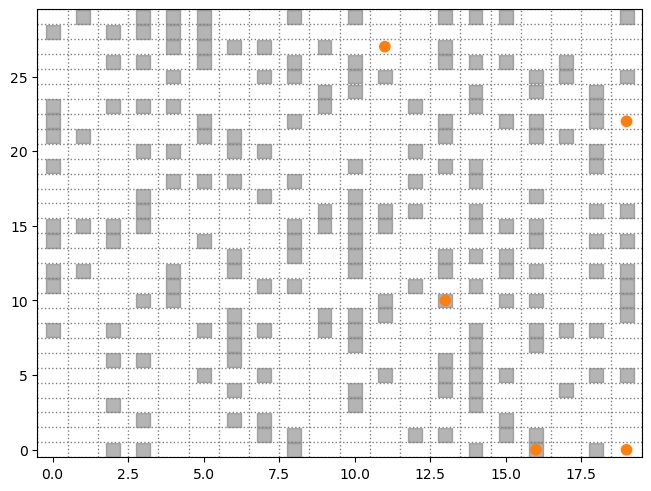

In [48]:

# -----------------------------
# Portrayal (colores)
# -----------------------------
def agent_portrayal(agent):
    if isinstance(agent, DirtCell):
        color = "#6b6b6b" if agent.dirty else "#FFFFFF"  # gris si sucia, verde si limpia
        return AgentPortrayalStyle(
            size=100, color=color, marker="s", alpha=0.5
        )
    if isinstance(agent, CleanAgent):
        return AgentPortrayalStyle(
            size=55, color="tab:orange", marker="o", alpha=1
        )
    return AgentPortrayalStyle(size=50, color="tab:blue")


# -----------------------------
# Controles (sliders) en la UI
# -----------------------------
model_params = {
    "num_agents": {"type": "SliderInt", "value": 5, "label": "Agents", "min": 1, "max": 100, "step": 1},
    "dirty_pct": {"type": "SliderFloat", "value": 0.333, "label": "Dirty %", "min": 0.0, "max": 1.0, "step": 0.01},
    "width": {"type": "SliderInt", "value": 20, "label": "Width", "min": 5, "max": 50, "step": 1},
    "height": {"type": "SliderInt", "value": 30, "label": "Height", "min": 5, "max": 50, "step": 1},
    "torus": {"type": "Checkbox", "value": False, "label": "Torus (wrap)"},
    "max_steps": {"type": "SliderInt", "value": 500, "label": "Max steps", "min": 10, "max": 20000, "step": 10},
    "seed": {"type": "SliderInt", "value": 42, "label": "Seed", "min": 0, "max": 10_000, "step": 1},
}


# -----------------------------
# Instancia + Visualizador
# -----------------------------
model = CleaningModel(
    width=model_params["width"]["value"],
    height=model_params["height"]["value"],
    num_agents=model_params["num_agents"]["value"],
    dirty_pct=model_params["dirty_pct"]["value"],
    max_steps=model_params["max_steps"]["value"],
    seed=model_params["seed"]["value"],
    torus=model_params["torus"]["value"],
)

renderer = SpaceRenderer(model=model, backend="matplotlib").render(
    agent_portrayal=agent_portrayal
)

page = SolaraViz(
    model,
    renderer,
    model_params=model_params,
    components=[],            # puedes añadir gráficos extra aquí
    name="Cleaning Model (SolaraViz)",
)

# En Jupyter, basta con evaluar esta celda:
page


=== Summary (APF) ===
Agents: 3 | Success prob: 0.15 | Mean time: 74.4 | Mean moves: 223.2
Agents: 4 | Success prob: 0.80 | Mean time: 66.2 | Mean moves: 265.0
Agents: 5 | Success prob: 0.91 | Mean time: 58.6 | Mean moves: 293.2
Agents: 10 | Success prob: 1.00 | Mean time: 34.2 | Mean moves: 341.8
Agents: 20 | Success prob: 1.00 | Mean time: 19.9 | Mean moves: 397.6
Agents: 50 | Success prob: 1.00 | Mean time: 10.3 | Mean moves: 516.5


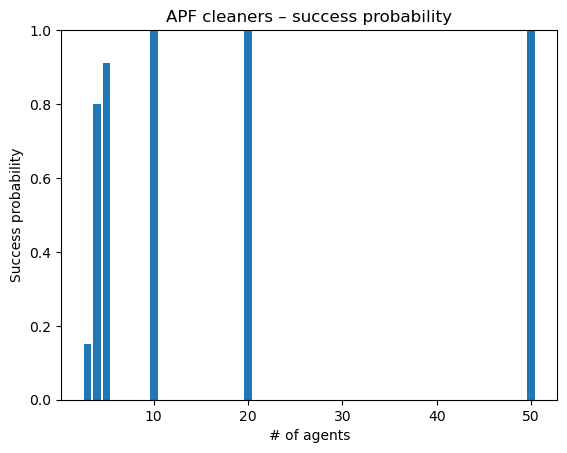

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def run_single_sim(
    num_agents: int,
    width: int = 20,
    height: int = 30,
    dirty_pct: float = 100 / (20 * 30), 
    max_steps: int = 500,
    seed: int | None = None,
    apf_params: dict | None = None,
):
    """
    Corre una simulación y regresa métricas básicas.
    """
    if apf_params is None:
        apf_params = {}

    model = CleaningModel(
        width=width,
        height=height,
        num_agents=num_agents,
        dirty_pct=dirty_pct,
        max_steps=max_steps,
        seed=seed,
        torus=False,
        **apf_params,
    )

    initial_dirty = len(model.dirty_cells)

    # Corre hasta que se acaben los pasos o se limpie todo
    while model.step_count < model.max_steps and model.time_to_all_clean is None:
        model.step()

    success = (
        model.time_to_all_clean is not None
        and model.time_to_all_clean <= max_steps
    )
    final_dirty = len(model.dirty_cells)
    cleaned = initial_dirty - final_dirty

    return {
        "success": success,
        "time": model.time_to_all_clean if model.time_to_all_clean is not None else max_steps,
        "moves": model.total_moves,
        "cleaned": cleaned,
        "final_dirty": final_dirty,
    }

def run_experiments(
    agent_counts=(3, 4, 5),
    num_runs: int = 100,
    base_seed: int = 42,
    **kwargs,
):
    """
    Corre num_runs simulaciones para cada número de agentes en agent_counts.
    Regresa un diccionario: {num_agents: [lista de resultados]}.
    """
    results = {}

    for n in agent_counts:
        runs = []
        for r in range(num_runs):
            seed = base_seed + r
            stats = run_single_sim(
                num_agents=n,
                seed=seed,
                **kwargs,
            )
            runs.append(stats)
        results[n] = runs

    return results

def summarize_results(results: dict):
    """
    Convierte el diccionario de resultados en estadísticas agregadas.
    """
    summary = {}

    for n, runs in results.items():
        successes = sum(1 for r in runs if r["success"])
        success_prob = successes / len(runs)

        times = [r["time"] for r in runs]
        moves = [r["moves"] for r in runs]

        summary[n] = {
            "success_prob": success_prob,
            "mean_time": float(np.mean(times)),
            "mean_moves": float(np.mean(moves)),
        }

    return summary

def plot_success_histogram(summary: dict, title: str = "APF cleaners"):
    agent_counts = sorted(summary.keys())
    success_probs = [summary[n]["success_prob"] for n in agent_counts]

    plt.figure()
    plt.bar(agent_counts, success_probs)
    plt.xlabel("# of agents")
    plt.ylabel("Success probability")
    plt.ylim(0.0, 1.0)
    plt.title(title)
    plt.show()

# Configuraciones que pide la tarea: 3, 4, 5 agentes
agent_counts = [3, 4, 5, 10, 20, 50]

# Corre 100 simulaciones por configuración
results = run_experiments(
    agent_counts=agent_counts,
    num_runs=100,
    max_steps=75,        # mismo max_steps que en el modelo
    dirty_pct=100 / 600,  # 100 celdas sucias en grid 20x30
)

# Resumen (prob. de éxito, tiempo promedio, movimientos promedio)
summary = summarize_results(results)

print("=== Summary (APF) ===")
for n in sorted(summary.keys()):
    s = summary[n]
    print(
        f"Agents: {n} | "
        f"Success prob: {s['success_prob']:.2f} | "
        f"Mean time: {s['mean_time']:.1f} | "
        f"Mean moves: {s['mean_moves']:.1f}"
    )

# Histograma de éxito
plot_success_histogram(summary, title="APF cleaners – success probability")


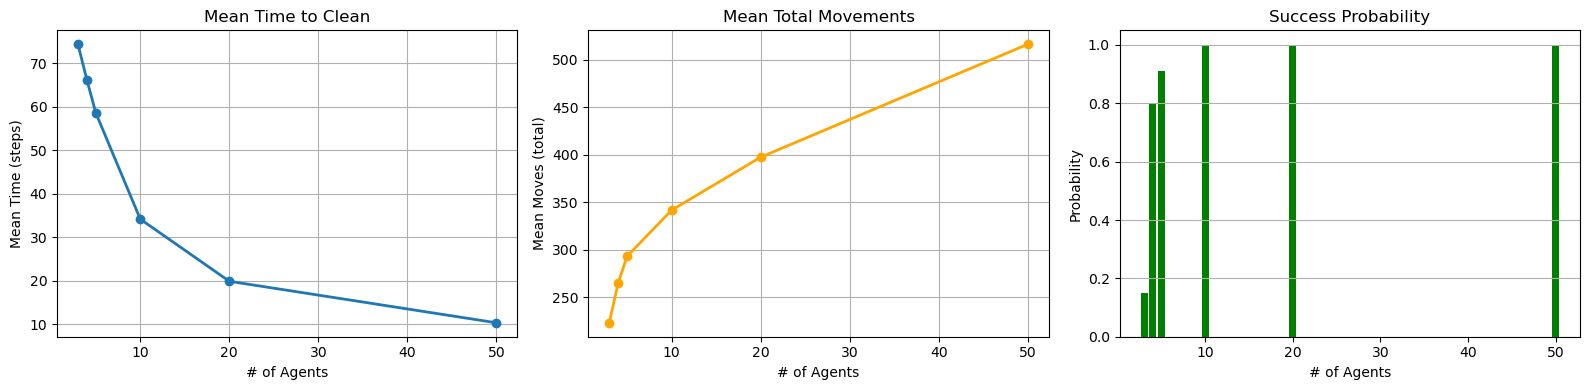

In [44]:
import matplotlib.pyplot as plt

def plot_comparison(summary):
    # Ordenar por número de agentes
    agent_counts = sorted(summary.keys())
    
    mean_times = [summary[n]["mean_time"] for n in agent_counts]
    mean_moves = [summary[n]["mean_moves"] for n in agent_counts]
    success_probs = [summary[n]["success_prob"] for n in agent_counts]

    plt.figure(figsize=(16, 4))

    # --- Gráfica 1: Mean Time ---
    plt.subplot(1, 3, 1)
    plt.plot(agent_counts, mean_times, marker="o", linewidth=2)
    plt.title("Mean Time to Clean")
    plt.xlabel("# of Agents")
    plt.ylabel("Mean Time (steps)")
    plt.grid(True)

    # --- Gráfica 2: Mean Moves ---
    plt.subplot(1, 3, 2)
    plt.plot(agent_counts, mean_moves, marker="o", color="orange", linewidth=2)
    plt.title("Mean Total Movements")
    plt.xlabel("# of Agents")
    plt.ylabel("Mean Moves (total)")
    plt.grid(True)

    # --- Gráfica 3: Success Probability ---
    plt.subplot(1, 3, 3)
    plt.bar(agent_counts, success_probs, color="green")
    plt.title("Success Probability")
    plt.xlabel("# of Agents")
    plt.ylabel("Probability")
    plt.ylim(0, 1.05)
    plt.grid(True, axis='y')

    plt.tight_layout()
    plt.show()

# Llamar a la función
plot_comparison(summary)
